# Calculating Delta F over F for analyzed timelapse for GCaMP experiments.
## This is a Python version of the deltaFOverF.m Matlab code that I previously made
In a paper from 2008 in Nature Neuroscience, DeltaF over F is defined as the following (Supplementary Methods from: Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).): Denote neuron fluorescence for frame i by F(i) (note that each neuron is processed separately). Define baseline fluorescence F0(i) as the mean of the lowest 50% of fluorescence values measured within some number of seconds before or after frame i, and **\[DeltaF/F0](i)** = (F(i) - F0)/F0. In this case, the number of seconds will be a variable number of frames before and after, which we will call 'window-frames'. Note that an alternative percentile-based approach for defining the F0 is also included in the analysis.

## Import libraries

In [1]:
import numpy as np
from numpy import matlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For finding multiple files with the same extension in a given path
import glob

# For interactive plotting
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 
import chart_studio.plotly as py

## Global variables
Change these variables if you would like a different sliding window, or a different value for defining what is actually an accepted peak (indicator of action potential) than the default for the deltaF/F0 calculation.

In [2]:
windowVal = 60; # Number of seconds on either side of a given frame. This will be fed into window_frames
peakThresh = 0.45; # Above this value of deltaF/F0, we consider a peak to be a firing event

axFontS = 16; # Fontsize for Graph Axes Labels
indxFontS = 12; # Fontsize for index labels on graphs (e.g., actual time point values)

## User-directed input - Part 1
Please change the following values for your particular dataset of interest.

**Change the path variable to the location of your data.**

In [3]:
path = '/Users/dtsloaner/Documents/GitHub/postdoc-scripts/gcamp' # change the path, if necessary

## Read Data
For this case, regions of interest were drawn around cells, neuropil, or a combination thereof in different regions of the zebrafish brain. The "Measure" tool was used in these regions to estimate the average intensity in that region for each time point in a time lapse movie. These values are stored in .csv files that are generated by Fiji. These .csv files can be immediately integrated into a growing dataframe, depending on how many columns are eventually desired.

The glob function allows one to make a list of all files with a particular extension within a given file path.

In [4]:
all_files_to_load = glob.glob(path + "/*.csv")

# Get each of the filenames, which will be used as column names for the dataframe
col_header = [[[all_files_to_load[i].split('.')[0] 
  for i in range(0,len(all_files_to_load))][li].split('/') 
 for li in range(0,len(all_files_to_load))][li2][-1] 
for li2 in range(0,len(all_files_to_load))]

Create a dataframe of intensity values. Each row represents a single time point in a time lapse movie. Each column represents a different *(i)* cell, *(ii)* region, or *(iii)* same region but different fish. Note that in the case of choosing the same region but different fish, ensure that the frame rate is the **same** for each fish, or else the graph will not be useful. Presumably, there are the same number of rows for each, but if there are not, the unfilled rows will just retain NaN values instead of actual numerical values.

In [5]:
df_intensities = pd.concat(
    (pd.read_csv(fnames,index_col=False,header=0,usecols=['y']).rename(
        columns={'y':col_header[all_files_to_load.index(fnames)]}) 
     for fnames in all_files_to_load),
    axis=1)

# In case you want to sort the column indices in numerical order, uncomment the next line
#df_intensities = df_intensities.sort_index(axis=1)

In [6]:
#df_intensities.head()
#df_intensities.info()
df_intensities.tail() # Not every row will be filled, oftentimes

,Fish-02_Results_11,Fish-03_Results_15,Fish-07_Results_48,Fish-03_Results_29,Fish-04_Results_16,Fish-04_Results_17,Fish-03_Results_28,Fish-03_Results_14,Fish-07_Results_49,Fish-02_Results_10,...,Fish-04_Results_33,Fish-03_Results_24,Fish-03_Results_30,Fish-03_Results_18,Fish-07_Results_45,Fish-07_Results_51,Fish-01_Results_56,Fish-01_Results_42,Fish-02_Results_34,Fish-02_Results_20
4290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1518.414,598.569,NaN,NaN
4291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1251.918,755.301,NaN,NaN
4292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,997.136,630.090,NaN,NaN
4293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1002.278,602.270,NaN,NaN
4294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1136.444,771.313,NaN,NaN


## User Directed Input - Part 2

**What is the time interval for a given frame in the time lapse (i.e., seconds per frame)?**

For each dataset that will be analyzed, please make timeInt into a dictionary of values, with the appropriate filename (without extension) as each key. (Even if only one dataset is added in, please make this a dictionary, or the program will throw a type error!)

For example, if each column has different times per frame (T<sub>1</sub>, T<sub>2</sub>, ..., T<sub>N</sub>), timeInt = \{'filename1':T<sub>1</sub>\, 'filename2':T<sub>2</sub>\, ..., 'filenameN':T<sub>N</sub>\}

In [7]:
#timeInt = {'fish4_NicotineAlone':1.9,'fish4_NicotineAlone2':1.9,'fish4_NicotineAlone3':1.9} # seconds per frame
#timeInt = {k:0.93 for k in df_intensities.columns}
fish1_frameRate={s:0.93 for s in df_intensities.columns if 'Fish-01' in s}
fish2_frameRate={s:1.13 for s in df_intensities.columns if 'Fish-02' in s}
fish3_frameRate={s:1.135 for s in df_intensities.columns if 'Fish-03' in s}
fish4_frameRate={s:1.9 for s in df_intensities.columns if 'Fish-04' in s}
fish6_frameRate={s:1.98 for s in df_intensities.columns if 'Fish-06' in s}
fish7_frameRate={s:1.99 for s in df_intensities.columns if 'Fish-07' in s}

# Note that the following way to concatenate dictionaries only works with Python versions 3.5 and above
timeInt = {**fish1_frameRate,**fish2_frameRate,**fish3_frameRate,**fish4_frameRate,
          **fish6_frameRate,**fish7_frameRate}

**Add in the frame number for each perturbation in a list format [perturbation1,perturbation2,...,perturbationN].**

If there are multiple files being added in and they have different frame numbers for their given perturbations, please make interv into a dictionary of lists, with the appropriate filename (without extension) as each key.

For example, if there were three perturbations at frames 100, 200, and 300 and each column has those same perturbations, input the following into the "interv" variable: interv = \[100, 200, 300\]

For example, imagine that there are three columns, each with three different frame numbers for perturbations (P<sub>1</sub>, P<sub>2</sub>, ..., P<sub>9</sub>), then the "interv" variable would become:  interv = \{'filename1':\[P<sub>1</sub>, P<sub>2</sub>, P<sub>3</sub>\], 'filename2':\[P<sub>4</sub>,P<sub>5</sub>,P<sub>6</sub>\], 'filename3':\[P<sub>7</sub>,P<sub>8</sub>,P<sub>9</sub>\]\}

In [8]:
#interv = {'fish4_NicotineAlone':[610,1085], 'fish4_NicotineAlone2':[610,1085], 'fish4_NicotineAlone3':[610,1085]}
#interv = {k:[1095,2180] for k in df_intensities.columns}
fish1_interv={s:[1095,2180] for s in df_intensities.columns if 'Fish-01' in s}
fish2_interv={s:[825,1640] for s in df_intensities.columns if 'Fish-02' in s}
fish3_interv={s:[815,1560] for s in df_intensities.columns if 'Fish-03' in s}
fish4_interv={s:[610,1085] for s in df_intensities.columns if 'Fish-04' in s}
fish6_interv={s:[534,990] for s in df_intensities.columns if 'Fish-06' in s}
fish7_interv={s:[1060] for s in df_intensities.columns if 'Fish-07' in s}

# Note that the following way to concatenate dictionaries only works with Python versions 3.5 and above
interv = {**fish1_interv,**fish2_interv,**fish3_interv,**fish4_interv,
          **fish6_interv,**fish7_interv}

Python is zero indexed, while most data acquisition programs are indexed at one (e.g., .lsm files from Zeiss ZEN software). If this is the case, then run the following cell to decrement the frame number by 1.

In [9]:
if type(interv)==list:
    interv[:] = [number - 1 for number in interv]
elif type(interv)==dict:
    for keys in interv:
        interv[keys][:] = [number - 1 for number in interv[keys]]
else:
    print('Error: Please check interv variable definition. interv should be a list OR a dictionary.')

## Calculating deltaF/F
Using the windowVal parameter to determine the range for the sliding window and generating a new dataframe containing the deltaF/F values.

Using the "ceil" function to make sure that the sliding window on either side of a given frame is an integer value of frames. (Feel free to replace this with "floor" or "round", if that is preferred.)

In [10]:
window_frames = {}
if type(timeInt)==dict:
    for keys in timeInt:
        window_frames[keys]=int(np.ceil(windowVal/timeInt[keys]))
else:
    print('Error: Please check timeInt variable definition. timeInt should be a dictionary.')

### Defining functions that calculate deltaF/F0 taking into account sliding window
In this case, we need to take care of the fact that there are going to be four different conditions. Let's consider a particular frame, *fnum*, within a time lapse of length *N* for these situations.

1. When *fnum* is < window_frames:

    - F0 is calculated from frame 0 to *fnum*+window_frames
    

2. When *fnum* is >= window_frames **and** *fnum* is <= *N*-window_frames:

    - F0 is calculated from frame *fnum*-window_frames to *fnum*+window_frames
    

3. When *fnum* is > *N*-window_frames:

    - F0 is calculated from frame *fnum*-window_frames to *N*
    

4. If there are NaN values in the array (i.e., if one column has fewer rows than others in the dataframe):

    - Let *num_nan* be the number of rows that have NaN values.

    *N_new* = *N*-*num_nan*

Note that in the case of (4), all of the previous 3 could be affected, so check for that immediately.

In [11]:
# Important functions that are called to calculate the F0 values
def F0Calc_percentile(intensityFrame,pcnt=20):
    """
    This function calculates F0 as defined in Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).
    
    Parameters
    ----------
    intensityFrame: Dataframe with rows containing intensity information at a given timepoint. Columns
        represent each region that was isolated from an image using e.g., region of interest measurements.
        Note that this is usually a sliding window subset of a total time lapse.
    pcnt: integer value between 1 and 99 (inclusive) that represents the percentile of data that will
        be used for the calculation.
        Default is 20th percentile.
        
    Returns
    ---------
    Dataframe
        Dataframe with F0 values calculated from input intensity values.
    """
    if type(intensityFrame)==pd.core.series.Series:
        return np.percentile(intensityFrame,pcnt)
    else:
        return [np.percentile(intensityFrame[column],pcnt) for column in intensityFrame]

def F0Calc_average(intensityFrame,pcnt=50):
    """
    This function calculates F0 as defined in Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).
    
    Parameters
    ----------
    intensityFrame: Dataframe with rows containing intensity information at a given timepoint. Columns
        represent each region that was isolated from an image using e.g., region of interest measurements.
        Note that this is usually a sliding window subset of a total time lapse.
    pcnt: integer value between 1 and 99 (inclusive) that represents the percentile of data that will
        be used for the calculation.
        Default is average of lowest 50% of values within the sliding window.
        
    Returns
    ---------
    Dataframe
        Dataframe with F0 values calculated from input intensity values.
    """
    if type(intensityFrame)==pd.core.series.Series:
        return np.average(np.sort(intensityFrame)[0:int(np.ceil(len(intensityFrame)*pcnt/100))])
    else:
        return [np.average(np.sort(intensityFrame[column])
                           [0:int(np.ceil(len(intensityFrame)*pcnt/100))]) for column in intensityFrame]

In [12]:
def deltaFOverFCalc(intensityFrame, slidingWindow = 10, method_F0 = 'average.50'):
    """
    This function calculates deltaF/F0 as defined in Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).
    
    Parameters
    ----------
    intensityFrame: Dataframe with rows containing intensity information at a given timepoint. Columns
        represent each region that was isolated from an image using e.g., region of interest measurements.
    slidingWindow: Number of frames to check ahead of and behind a given frame during the analysis to
        calculate F0. This must be an integer value, but if it is not, it will become an integer with ceil().
        Default sliding window is 10 frames.
    method_F0: String to indicate which of two methods to use for calculating F0.
        'average.X': using the average of the lowest X% values within the sliding window as F0.
        'percentile.X': using the percentile function to figure out Xth percentile value for the sliding
            window and using that as F0.
        X must be between 1 and 99, inclusive.
        Default method is average of lowest 50% of values within the sliding window.
        
    Returns
    ---------
    Dataframe
        Dataframe with deltaF/F0 values calculated from input intensity values.
    """
    # Extracting the method used to calculate F0
    [method_used,pcntg]=method_F0.split('.')
    # Make sure percentage pcntg is an integer (again, needs to be between 1 and 99)
    pcntg = int(pcntg)
    
    # Total number of frames for each column in the dataframe
    num_fram = intensityFrame.count().to_list() # count neglects NaN values!
    
    # First, find the minimum length column in the dataframe.
    lowest_frame_num = min(num_fram)
    # Second, find the maximum number of sliding window frames used in the columns.
    highest_sliding_window = slidingWindow[max(slidingWindow.keys(), key=(lambda k: slidingWindow[k]))]
    # If the sliding window is larger than the total number of timepoints,
    #     then, F0 needs to be calculated based on all frames in the dataframe.
    if highest_sliding_window > lowest_frame_num:
        if method_used == 'percentile':
            F0_val = F0Calc_percentile(intensityFrame,pcntg)
        elif method_used == 'average':
            F0_val = F0Calc_average(intensityFrame,pcntg)
        else:
            # Default will be average of lowest 50% of values of all timepoints in each column
            F0_val = F0Calc_average(intensityFrame,50)
            
            
    # Otherwise, we can use the sliding window approach for cases 1-3.
    else:
        # Initialize F0_val with NaN values
        F0_val = np.matlib.repmat(np.NaN,len(intensityFrame),len(intensityFrame.columns))
        F0_val= pd.DataFrame(data=F0_val,columns=intensityFrame.columns)
        for column in intensityFrame:
            for fnum in range(0,len(intensityFrame[column])):
                if method_used == 'percentile':
                    if fnum < slidingWindow[column]:
                        F0_val[column][fnum] = F0Calc_percentile(
                            intensityFrame[column][0:fnum+slidingWindow[column]],pcntg)
                    elif fnum >= slidingWindow[column] and fnum <= len(intensityFrame[column])-slidingWindow[column]:
                        F0_val[column][fnum] = F0Calc_percentile(
                            intensityFrame[column]
                            [fnum-slidingWindow[column]:fnum+slidingWindow[column]],pcntg)
                    else:
                        F0_val[column][fnum] = F0Calc_percentile(
                            intensityFrame[column]
                            [fnum-slidingWindow[column]:len(intensityFrame[column])],pcntg)
                # for when the method used is average (or default)
                else:
                    if fnum < slidingWindow[column]:
                        F0_val[column][fnum] = F0Calc_average(
                            intensityFrame[column][0:fnum+slidingWindow[column]],pcntg)
                    elif fnum >= slidingWindow[column] and fnum <= len(intensityFrame[column])-slidingWindow[column]:
                        F0_val[column][fnum] = F0Calc_average(
                            intensityFrame[column]
                            [fnum-slidingWindow[column]:fnum+slidingWindow[column]],pcntg)
                    else:
                        F0_val[column][fnum] = F0Calc_average(
                            intensityFrame[column]
                            [fnum-slidingWindow[column]:len(intensityFrame[column])],pcntg)
    
    # Return element by element subtraction followed by division of F0_val (F-F0)/F0
    return intensityFrame.subtract(F0_val).divide(F0_val)

## Calculate DeltaF/F0 using functions described above
Create a dataframe of DeltaF/F0 values.

In [13]:
df_dFOverF = deltaFOverFCalc(intensityFrame=df_intensities, slidingWindow = window_frames, method_F0 = 'average.50')

In [14]:
df_dFOverF.head(31)

,Fish-02_Results_11,Fish-03_Results_15,Fish-07_Results_48,Fish-03_Results_29,Fish-04_Results_16,Fish-04_Results_17,Fish-03_Results_28,Fish-03_Results_14,Fish-07_Results_49,Fish-02_Results_10,...,Fish-04_Results_33,Fish-03_Results_24,Fish-03_Results_30,Fish-03_Results_18,Fish-07_Results_45,Fish-07_Results_51,Fish-01_Results_56,Fish-01_Results_42,Fish-02_Results_34,Fish-02_Results_20
0,0.225196,0.025038,-0.124433,0.266718,0.010809,0.203802,0.068866,0.565400,0.042416,0.255969,...,0.263299,1.005702,0.762243,1.020458,0.258791,0.170974,0.088633,0.524093,0.352818,0.254387
1,-0.081651,-0.016547,-0.118773,0.324743,-0.310437,0.289180,0.058258,0.457211,-0.039982,0.264963,...,0.161943,0.218643,0.375064,0.772360,0.290596,0.027795,0.138070,0.126837,0.983340,1.144842
2,0.181442,0.145453,0.241521,0.299830,-0.214043,0.305843,0.142765,-0.008989,0.358987,0.193988,...,0.215264,0.592895,0.892826,0.429222,0.180931,0.069484,0.593362,0.380824,0.644002,0.445923
3,0.079795,0.273961,-0.094889,0.963936,-0.180447,0.293895,0.317565,0.075681,0.150669,0.302967,...,-0.009832,0.100799,0.882927,0.798736,0.195884,0.308805,0.536826,0.272556,0.355813,0.720226
4,0.248106,0.218689,0.160041,0.360769,0.832044,0.337999,-0.009142,0.258670,0.280854,-0.004880,...,0.059699,0.440252,0.345094,0.852937,-0.089565,0.103682,0.248741,0.542477,0.271864,0.217195
5,0.081970,0.364550,0.069852,0.454823,0.420207,0.777677,0.134357,1.444683,-0.038327,-0.189167,...,0.555210,1.114752,0.275545,1.348120,0.041458,0.199123,0.294315,-0.051172,0.186332,-0.199015
6,-0.018629,2.093027,0.139474,0.238730,0.341725,0.289836,0.974046,1.747428,0.009916,0.627917,...,0.288740,2.373855,0.053778,2.135170,0.182996,0.195045,0.231327,0.614161,0.182956,-0.146482
7,0.044753,2.177507,0.075623,0.155652,0.324888,-0.017908,0.487089,1.601010,0.346139,0.084326,...,-0.107305,1.780698,0.290596,1.842273,0.167757,0.069115,0.163951,-0.023190,0.506793,0.180991
8,0.159308,1.804959,0.023891,0.622852,0.650447,0.019647,-0.049875,1.270755,-0.082793,1.053310,...,0.272646,1.184837,0.539565,1.727902,0.143423,-0.052229,0.276405,0.088172,0.736697,-0.015208
9,0.944538,2.303509,0.340254,0.908310,0.196912,0.264737,0.264468,1.100929,0.165845,0.061950,...,0.130558,0.771586,0.759350,1.952332,0.027395,0.125654,0.329961,0.284869,0.682214,0.365762


## Making Time Interval Dataframes

Since each column may have different time intervals associated with them (e.g., if different fish are concatenated together into the original df_intensities dataframe), we want to generate a new dataframe for the time interval that has the same column indexing as the original dataframes. Ultimately, we will use this to generate a [Hierarchical dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) that will contain intensity data, DeltaF/F0 calculations, timepoints for each frame, and indicators for when interventions are added.

In [15]:
time_values = pd.DataFrame({},columns=df_intensities.columns)
if type(timeInt)==dict:
    for col in df_intensities:
        time_values[col] = np.linspace(start = 0, stop = df_intensities.count().max()*timeInt[col],
                                   endpoint = False, num = df_intensities.count().max(),retstep=timeInt[col])[0]
else:
    print('Error: Please check timeInt variable definition. timeInt should be a dictionary.')

## Making Dataframe out of Intervention Information

Each fish may have been treated with a particular compound at a certain frame number. We will save each intervention as an incrementing numerical value in a particular column. So, for example, if there are 3 interventions, each at frame 100, 200, and 300 (assume zero indexing here, so really those frames instead of frame-1) in a given file, then the column for this intervention dataframe would contain all zeroes, except at frames 100, 200, and 300. Frame 100 would contain the value 1, frame 200 would contain the value 2, and frame 300 would contain the value 3.

In [16]:
interventions = pd.DataFrame({},columns=df_intensities.columns)
# See if the type of the interv variable is list or dict
if type(interv)==list:
    for col in df_intensities:
        interventions[col] = np.matlib.repmat(a=0,n=df_intensities.count().max(),m=1)[0]
        # a list of lists is created, so add in the the zeroth entry, the list
        counter = 1
        for num in interv:
            interventions.loc[num,col]=counter
            counter = counter + 1
elif type(interv)==dict:
    for col in df_intensities:
        interventions[col] = np.matlib.repmat(a=0,n=df_intensities.count().max(),m=1)[0]
        # a list of lists is created, so add in the the zeroth entry, the list
        counter = 1
        for num in interv[col]:
            interventions.loc[num,col]=counter
            counter = counter + 1
else:
    print('Error: Please check interv variable definition. interv should be a list OR a dictionary.')

## Saving Intensity and DeltaF/F0 Dataframes

Make a new output directory (see [making directories](https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir) in python documentation) and then save the raw intensity and DeltaF/F0 dataframes, in case they need to be referenced later.

In [17]:
# Import library for generating a new path - making an output directory
from pathlib import Path
outputDirectory = "/output/"
# Check to see if the output directory already exists using Path.mkdir
Path(path+outputDirectory).mkdir(parents=True, exist_ok=True)

df_intensities.to_csv(path + outputDirectory + 'RawIntensity_Dataframe.csv',index=False)
df_dFOverF.to_csv(path + outputDirectory + 'DeltaFOverF_Dataframe.csv',index=False)
#Index is just the row numbers, unnecessary to keep, which is why "index=False" is there

### Read in Dataframes (only if they already exist)

If Intensity and DeltaF/F0 Dataframes have already been saved in the *output/* directory previously, just read in these dataframes directly instead of using the "Read Data" section. (This way, you do not need to recalculate DeltaF/F0 every time you use this notebook, which is the most expensive section computationally.)

In [ ]:
df_intensities = pd.read_csv(path + "/output/" + "RawIntensity_Dataframe.csv")
df_dFOverF = pd.read_csv(path + "/output/" + "DeltaFOverF_Dataframe.csv")

## Making MultiIndex Dataframe for intensity, DeltaF/F0,time interval, and interventions
Now, combine all of the separate dataframes into one multiframe dataframe. This will make things easier for plotting later.

In [18]:
data_dictionary = {'Intensity Values':df_intensities,
                   'DeltaF/F0 Values':df_dFOverF,
                   'Timepoints':time_values,
                   'Intervention Frames':interventions}
all_data = pd.concat(data_dictionary,axis=1,keys=data_dictionary.keys(),join='outer')

# This just shows the header for an adjusted dataframe to show intensity and DeltaF/F0 side-by-side for each timepoint
all_data.xs(key=list(all_data.columns.levels[1])[0],axis='columns',level=1).set_index('Timepoints').head()

,Intensity Values,DeltaF/F0 Values,Intervention Frames
Timepoints,,,
0.00,851.307,0.225196,0
1.13,641.924,-0.081651,0
2.26,818.207,0.181442,0
3.39,744.287,0.079795,0
4.52,860.124,0.248106,0


### Saving MultiIndex Dataframe
Save the MultiIndex Dataframe in the same output path as the individual Intensity or DeltaF/F0 dataframes

In [19]:
from pathlib import Path
outputDirectory = "/output/"
# Check to see if the output directory already exists using Path.mkdir
Path(path+outputDirectory).mkdir(parents=True, exist_ok=True)

all_data.to_csv(path + outputDirectory + 'fullData_Dataframe.csv',index=False)

### Importing MultiIndex Dataframe
Import the saved MultiIndex Dataframe, if it exists.

In [ ]:
all_data = pd.read_csv(path + "/output/" + "fullData_Dataframe.csv")

## Plotting \*\*\*\*(IN PROGRESS AS OF 2020-06-12)\*\*\*\*
Here, plot deltaF/F0 as well as the intensity plot, and indicate where interventions (e.g., drugs) were added.

### Default Plot Visualization Settings
Here, you can change the general way that plots look going forward. The default plotstyle is 'seaborn-darkgrid' (similar to 'ggplot'), which makes the plotted lines stand out from the background well. 'default' makes a white background with large fonts, which is also nice for publications.

See the ["using style sheets"](https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files) tutorial for matplotlib to see other style parameters that can be adjusted. Feel free to adjust any of these default parameters as you see fit.

In [20]:
plt.style.use('seaborn-darkgrid') # Sets general features of the plot; default: 'seaborn-darkgrid'
plt.rcParams['font.size'] = 12 # Size of axis label font; default: 12
plt.rcParams['font.weight'] = 'bold' # adjusts axis label font weight; default: 'bold'
plt.rcParams['savefig.dpi'] = 300 # dpi for saved figures; default: 300
plt.rcParams['savefig.dpi'] = 100 # dpi for display figures (smaller to take less time); default: 100
plt.rcParams['figure.figsize'] = [10.0, 3.0] # Size of figure to display after running a cell; default: [10.0, 3.0]
plt.rcParams['axes.labelsize'] = 20 # adjust x and y labels font size; default: 20
plt.rcParams['axes.labelweight'] = 'bold' # adjusts x and y labels; default: 'bold'
plt.rcParams['axes.spines.top'] = False # Removes the top line on a graph; default: False
plt.rcParams['axes.spines.right'] = False # Removes the rightmost line on a graph; default: False

# Add the following after any plots with multiple elements that have squeezed text or figures
#plt.tight_layout() # For plots with multiple subplots, makes sure text and figures are spread out

**Debugging step**:
This first plot is a debugging plot that is recommended if you do not believe that the program is calculating deltaF/F0 in a satisfactory way. Here, the first 10 frames of the time lapse are used to calculate deltaF/F0 and a plot is generated for these first 10 frames versus the first 10 frames calculated from the full time lapse. Presumably, the trend should be pretty similar.

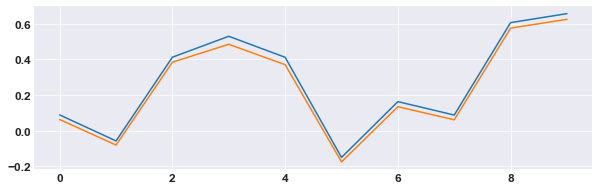

In [22]:
# Debug: Test to see what happens when the length of the Dataframe being passed 
#   into deltaFOverFCalc is smaller than slidingWindow.
df_dFOverF2 = deltaFOverFCalc(intensityFrame=df_intensities.head(10),
                              slidingWindow = window_frames, method_F0 = 'average.50')

# Debugging, just seeing that the trend is the same for the calculation of dF/F0 when the dataframe is full
#    versus when it is just the first 10 values. (df_dFOverF versus df_dFOverF2, respectively)
df_dFOverF['Fish-01_Results_0'][0:10].plot()
df_dFOverF2['Fish-01_Results_0'].plot()

### Determining Frames for Averaging
Next, we want to average the DeltaF/F0 values for baseline and after each treatment. To determine the number of frames to average, we should take into account the minimum amount of **time** between interventions for a particular fish. So, look through the 'Intervention Frames' for the *all_data* dataframe to see what the minimim number of rows is between a given pair of interventions (and we need to take into account the frame rates, in case they are different, too). 

For example, if there are 3 interventions (all with the same frame rate), one at frame 100, one at frame 500, and one at frame 520, then the minimum number of frames to consider would be the one between the second and third intervention (minimum frames = 20).

In [168]:
all_interventions = []
sec_per_frame = []
for cols in all_data.columns.levels[1]:
    # Note: inserting a "0" value to make the subtraction easier, because the baseline starts at the first frame
    all_interventions.append(list(all_data[all_data['Intervention Frames'][cols]>0].index.insert(0,0)))
    # Now, use the second column for each Timepoints entry for the value of the frame rate (#sec per frame)
    sec_per_frame.append(all_data['Timepoints'][cols][1])
    
# Now, only keep the unique lists inside using "set" and "tuple"
#all_interventions = set(tuple(x) for x in all_interventions)
#time_of_interventions = []
all_interventions[1]



[0, 814, 1559]

Now, add time information to the intervention frames. We will need numpy arrays for this, because float values cannot be multiplied to lists in Python. Yes, we could have gotten this list from the 'interv' variable, but in case the all_data dataframe was just loaded instead of created from scratch, this cell above is the safer way to determine the minimum amount of time between interventions (or between the first timepoint and first intervention, or between the last intervention and the last timepoint). 

In [182]:
all_interventions = [np.array(xi) for xi in all_interventions]

time_of_interventions = [entry * timVal for timVal in sec_per_frame for entry in all_interventions]

# Minimum time between interventions, start it with an impossibly high value that will be decreased
minimum_time = 10000000000
for element in time_of_interventions:
    for nvals in range(0,len(element)-1):
        dummy = element[nvals+1]-element[nvals]
        if dummy == 0:
            pass
        elif dummy < minimum_time:
            minimum_time=dummy
        elif dummy > minimum_time:
            pass
        else:
            pass

Now that we have the minimum amount of time between interventions, let's floor that to the nearest *roundTo* timepoint (input by the user, typically floor to the nearest 60 seconds).

In [196]:
roundTo = 100 # rounding to the nearest roundTo time

We will take *bufferTime* number of seconds out from the last intervention and back from the next intervention just to account for edge effects (e.g., in case we weren't exactly correct about the frame number of the actual intervention or in case the intervention causes a spike in activity that is actually just a movement artifact from the pipette going in). Note that buffer time should take on a small value (at least <60 seconds), because the interventions are likely to be at least correct on the scale of tens of seconds.

In [203]:
bufferTime = np.floor(np.remainder(minimum_time,roundTo)*.5)/2

Now, calculate the entire period of time that we will split in half to calculate the average DeltaF/F0 measure in that time window.

In [204]:
framePeriods = np.floor(minimum_time/roundTo)*roundTo/2

Now, we need to, for every DeltaF/F0 column, figure out which are the closest frame numbers associated with *framePeriods* and *bufferTime*. 

As an example, let's say the movie starts at Frame 0 and the first intervention is at Frame 999 (1000 total frames), and there is a 0.5 second per frame interval between frames (so, the movie is 500 seconds total). If the framePeriods was found to be 30 seconds and bufferTime was found to be 2 seconds, then we would want the DeltaF/F0 values for rows (2/0.5) = 4 to (30/0.5+2/0.5)-1 = 63 for the initial average (60 frames), and then rows 999-(30/0.5+2/0.5)+1 = 936 to 999-(2/0.5) = 995 (60 frames). Note that we subtract or add 1 in some cases because of zero indexing.

# /*/*/*/*LEFT OFF HERE 6/12/2020/*/*/*/*

424.0800000000001

## Probably Delete later - Finding minimum number of frames to use based on frames but not based on the actual time for each frame. (Note made 6/12/2020)

Yes, we could have gotten this list from the 'interv' variable, but in case the *all_data* dataframe was just loaded instead of created from scratch, this cell above is the safer way to generate the set. Now, figure out the minimum amount of time between interventions, which will use information about the time interval for each fish.

In [83]:
frame_ranges = []
for element in all_interventions:
    for nvals in range(0,len(element)-1):
        frame_ranges.append(list(element)[nvals+1]-list(element)[nvals])
        
minimum_frames = min(frame_ranges)
minimum_frames

456

Once we know the minimum number of frames, we nee

Now that we have the minimum number of frames between interventions, let's floor that to the nearest hundred frames and then split the range in two so that we have a just after the first intervention and then just before the next intervention. This rounding allows us to have a buffer of frames, which we can determine based on the remainder after rounding.

In [74]:
roundTo = 100 # rounding to the nearest roundTo frames

We will go bufferFrames number of frames out from the last intervention and back from the next intervention just to account for edge effects (e.g., in case we weren't exactly correct about the frame number of the actual intervention or in case the intervention causes a spike in activity that is actually just a movement artifact from the pipette going in). Note that buffer frames should probably be a small number of frames, if any.

In [81]:
bufferFrames = int(np.floor(np.floor(np.remainder(minimum_frames,roundTo)*.2)/2))

Now, calculate the entire period of time that we will split in half to calculate the average DeltaF/F0 measure in that time window.

In [82]:
framePeriods = int(np.floor(np.floor(minimum_frames/roundTo)*roundTo/2))

200

### Averaging frames between interventions
Now, calculate the average DeltaF/F0 value for each fish within the 

In [ ]:
#all_data['Intervention Frames'].loc[all_data['Intervention Frames']['Results_0']>0]
DDD=all_data[all_data['Intervention Frames']['Results_0']>0].index.insert(0,0)
#len(list(DDD))
list(DDD)
#DDD = [1,200,300,400]
#EEE = zip(DDD,DDD[1:])
#list(EEE)
#DDD.insert(0,0)
#DDD

In [ ]:
timeInt

In [ ]:
df_intensities['Results_0'].plot()

In [ ]:
df_dFOverF['Results_0'].plot()

In [ ]:
XXX = {k:0.93 for k in df_intensities.columns}
#df_intensities.columns
YYY={s:0.93 for s in df_intensities.columns if 'Fish-01' in s}
ZZZ={s:1.13 for s in df_intensities.columns if 'Fish-02' in s}
EEE = {**YYY,**ZZZ}
EEE
FFF = {[s:1.135 for s in df_intensities.columns if 'Fish-03' in s],[d:1.9 for d in df_intensities.columns if 'Fish-03' in d]}
FFF

SyntaxError: invalid syntax (<ipython-input-98-d80c987ced42>, line 1)

In [133]:
#sec_per_frame[i] * s for s in all_interventions[i] for i in sec_per_frame
#[entry for tag in tags for entry in entries if tag in entry]
[entry * timVal for timVal in sec_per_frame for entry in all_interventions]

[array([   0.  ,  931.12, 1852.07]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  , 1196.67]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  , 1196.67]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  6

In [174]:
a = np.array([1, 0, 0], [1, 0], [2, 3, 4])
a

ValueError: only 2 non-keyword arguments accepted

In [180]:
time_of_interventions

[array([   0.  ,  931.12, 1852.07]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  , 1196.67]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  , 1196.67]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  ,  931.12, 1852.07]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  , 1236.22, 2462.27]),
 array([   0.  ,  919.82, 1761.67]),
 array([   0.  ,  688.17, 1224.92]),
 array([   0.  ,  6